In [1]:
import pandas as pd
import numpy as np

import emcee
import scipy.optimize as op
import scipy
import corner
from multiprocessing import Pool
import multiprocessing
import time

from astropy.table import Table
import astropy


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib

In [2]:
%matplotlib notebook

In [3]:
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('astropy version: {}'.format(astropy.__version__))
print('emcee version: {}'.format(emcee.__version__))
print('scipy version: {}'.format(scipy.__version__))

numpy version: 1.15.4
pandas version: 0.23.4
matplotlib version: 3.0.1
astropy version: 3.1.1
emcee version: 3.0rc2
scipy version: 1.2.0


# Figure 9

Create Figure 9 (the Redshift Completeness Factor as a function of observed galaxy brightness based on ZTF BTS data) in [Fremling et al. 2020](https://ui.adsabs.harvard.edu/abs/2019arXiv191012973F/abstract).

In [4]:
# BTS data
bts_df = pd.read_hdf('../data/final_rcf_table.h5')

In [5]:
z_sn = bts_df.z_sn.values
z_host = bts_df.z_host.values

norm_Ia = np.where( ( (bts_df.sn_type == 'Ia-norm') | 
                      (bts_df.sn_type == 'Ia') | 
                      (bts_df.sn_type == 'Ia-91bg') | 
                      (bts_df.sn_type == 'Ia-91T') | 
                      (bts_df.sn_type == 'Ia-99aa') | 
                      (bts_df.sn_type == 'ia')
                     | (bts_df.sn_type == 'Ia-norm*')
                     | (bts_df.sn_type == 'Ia-91T*')
                     | (bts_df.sn_type == 'Ia-91T**')
                     | (bts_df.sn_type == 'SN Ia')
                    )
                  )

norm_cc = np.where( (bts_df.sn_type == 'IIb') | 
                    (bts_df.sn_type == 'Ib') | 
                    (bts_df.sn_type == 'IIP') | 
                    (bts_df.sn_type == 'Ib/c') | 
                    (bts_df.sn_type == 'Ic-norm') | 
                    (bts_df.sn_type == 'IIn') | 
                    (bts_df.sn_type == 'IIL') | 
                    (bts_df.sn_type == 'Ic-broad') | 
                    (bts_df.sn_type == 'II') | 
                    (bts_df.sn_type == 'II-pec') | 
                    (bts_df.sn_type == 'Ib-pec') | 
                    (bts_df.sn_type == 'Ic') | 
                    (bts_df.sn_type == 'Ic-BL') | 
                    (bts_df.sn_type == 'IIP*') | 
                    (bts_df.sn_type == 'II*') | 
                    (bts_df.sn_type == 'Ibn') | 
                    (bts_df.sn_type == 'II**') | 
                    (bts_df.sn_type == 'Ib-norm') | 
                    (bts_df.sn_type == 'IIn*')
                  )

has_host_z = np.where((z_host > 0) & np.isfinite(z_host))
no_host = np.where((z_host < 0) | np.isnan(z_host))

has_host_cc = np.intersect1d(has_host_z, norm_cc)
has_host_ia = np.intersect1d(has_host_z, norm_Ia)

no_host_cc = np.intersect1d(no_host, norm_cc)
no_host_ia = np.intersect1d(no_host, norm_Ia)

z_mix = z_sn.copy()
z_mix[has_host_z] = z_host[has_host_z]

In [6]:
# prep data for analysis
hit_idx = np.where(np.isfinite(bts_df.z_host)
                   & (bts_df.z_host > 0)
                    & np.isfinite(bts_df.sep)
                    & (bts_df.sn_type != 'ambiguous')
                   )
miss_idx = np.where(np.isfinite(bts_df.z_host)
                    & (bts_df.z_host == -999)
                    & np.isfinite(bts_df.sep)
                    & (bts_df.sn_type != 'ambiguous')
                   )

ps1_r_det = np.where(np.isfinite(bts_df.rKron_PS1) & (bts_df.rKron_PS1.values > 0))
ps1_r_hit = np.intersect1d(hit_idx, ps1_r_det[0])
ps1_r_miss = np.intersect1d(miss_idx, ps1_r_det[0])

print('There are {} galaxies with r-band detections'.format(len(ps1_r_det[0])))

There are 683 galaxies with r-band detections


In [7]:
ps1_i_det = np.where(np.isfinite(bts_df.iKron_PS1) & (bts_df.iKron_PS1.values > 0))
ps1_i_hit = np.intersect1d(hit_idx, ps1_i_det[0])
ps1_i_miss = np.intersect1d(miss_idx, ps1_i_det[0])

print('There are {} galaxies with i-band detections'.format(len(ps1_i_det[0])))

There are 680 galaxies with i-band detections


In [8]:
# values for analysis
in_ned_ps1 = np.append(np.ones_like(z_mix[ps1_r_hit]), 
                   np.zeros_like(z_mix[ps1_r_miss])
                  )
r_mag_ps1 = np.append(bts_df.rKron_PS1[ps1_r_hit], bts_df.rKron_PS1[ps1_r_miss])
z_ps1 = np.append(z_mix[ps1_r_hit], z_mix[ps1_r_miss])

### Get p(m_obs)

In [9]:
def p_z(x, a, c):
    return 1 / (1 + np.exp(a*x - c))

def lnprior_z(theta):
    a, c = theta
    if (0 < a < 1e6) and (-100 < c < 100):
        return 0.
    return -np.inf

def lnlike_z(theta, trials, x):
    a, c = theta

    return np.sum(np.log([scipy.stats.bernoulli.pmf(t, _p) for t, _p in zip(trials, p_z(x, a, c))]))

def lnprob_z(theta, trials, x):
    lp = lnprior_z(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_z(theta, trials, x)

In [10]:
nll = lambda *args: -lnlike_z(*args)
result = op.minimize(nll, [(1, 16)], args=(in_ned_ps1, r_mag_ps1))
b, c = result["x"]

ndim, nwalkers = 2, 20
pos_ps1 = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
max_n = 5000

In [11]:
old_tau = np.inf
with Pool(4) as pool:
    sampler_ps1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_z, 
                                      args=(in_ned_ps1, r_mag_ps1), 
                                      pool=pool)
    start = time.time()
    for sample in sampler_ps1.sample(pos_ps1, iterations=max_n, progress=True):
        if sampler_ps1.iteration % 100:
            continue

        tau = sampler_ps1.get_autocorr_time(tol=0)

        # Check convergence
        converged = np.all(tau * 100 < sampler_ps1.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau    
    
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

 66%|██████▌   | 3300/5000 [21:07<09:59,  2.83it/s]

Multiprocessing took 1267.9 seconds


In [12]:
ps1_grid = np.linspace(8, 24, 1000)
autocorr_ps1 = sampler_ps1.get_autocorr_time(tol=0)
n_burn_ps1 = 5*np.ceil(np.max(autocorr_ps1)).astype(int)
samples_ps1 = sampler_ps1.get_chain(discard=50, flat=True)

p_ps1_1d_grid = np.empty((len(ps1_grid),len(samples_ps1)))
for grid_num, ps1_w1 in enumerate(ps1_grid):
    p_ps1_1d_grid[grid_num] = p_z(ps1_w1, samples_ps1[:,0], samples_ps1[:,1])
p_ps15, p_ps150, p_ps195 = np.percentile(p_ps1_1d_grid, (5,50,95), axis=1)

### Same thing, but just things within the SDSS footprint

In [13]:
in_sdss_df = Table.read('../data/RCF_has_SDSS_adammiller.fit').to_pandas()

In [14]:
sdss_footprint = np.zeros_like(bts_df.rKron_PS1).astype(bool)
for zn in in_sdss_df.ZTF_Name:
    sdss_footprint[bts_df.ZTF_Name == zn.decode('utf-8')] = 1

In [15]:
ps1_sdss = np.where(np.isfinite(bts_df.rKron_PS1) & (bts_df.rKron_PS1 > 0) & sdss_footprint)
ps1_sdss_hit = np.intersect1d(hit_idx, ps1_sdss[0])
ps1_sdss_miss = np.intersect1d(miss_idx, ps1_sdss[0])
print('There are {} sources with SDSS imaging'.format(len(ps1_sdss[0])))

There are 516 sources with SDSS imaging


In [16]:
in_ned_ps1_sdss = np.append(np.ones_like(z_mix[ps1_sdss_hit]), 
                   np.zeros_like(z_mix[ps1_sdss_miss])
                  )
r_mag_ps1_sdss = np.append(bts_df.rKron_PS1[ps1_sdss_hit], bts_df.rKron_PS1[ps1_sdss_miss])
z_ps1_sdss = np.append(z_mix[ps1_sdss_hit], z_mix[ps1_sdss_miss])

In [17]:
nll = lambda *args: -lnlike_z(*args)
result = op.minimize(nll, [(1, 16)], args=(in_ned_ps1_sdss, r_mag_ps1_sdss))
b, c = result["x"]

ndim, nwalkers = 2, 20
pos_ps1_sdss = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
max_n = 5000

In [18]:
old_tau = np.inf
with Pool(4) as pool:
    sampler_ps1_sdss = emcee.EnsembleSampler(nwalkers, ndim, lnprob_z, 
                                      args=(in_ned_ps1_sdss, r_mag_ps1_sdss), 
                                      pool=pool)
    start = time.time()
    for sample in sampler_ps1_sdss.sample(pos_ps1, iterations=max_n, progress=True):
        if sampler_ps1_sdss.iteration % 100:
            continue

        tau = sampler_ps1_sdss.get_autocorr_time(tol=0)

        # Check convergence
        converged = np.all(tau * 100 < sampler_ps1_sdss.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau    
    
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

 66%|██████▌   | 3300/5000 [14:50<07:21,  3.85it/s]

Multiprocessing took 890.3 seconds


In [19]:
autocorr_ps1_sdss = sampler_ps1_sdss.get_autocorr_time(tol=0)
n_burn_ps1_sdss = 5*np.ceil(np.max(autocorr_ps1_sdss)).astype(int)
samples_ps1_sdss = sampler_ps1_sdss.get_chain(discard=50, flat=True)

p_ps1_sdss_1d_grid = np.empty((len(ps1_grid),len(samples_ps1_sdss)))
for grid_num, ps1_w1 in enumerate(ps1_grid):
    p_ps1_sdss_1d_grid[grid_num] = p_z(ps1_w1, samples_ps1_sdss[:,0], samples_ps1_sdss[:,1])
p_ps1_sdss5, p_ps1_sdss50, p_ps1_sdss95 = np.percentile(p_ps1_sdss_1d_grid, (5,50,95), axis=1)

#### What about outside SDSS?

In [20]:
no_sdss_footprint = sdss_footprint*-1+1

In [21]:
no_sdss = np.where(np.isfinite(bts_df.rKron_PS1) & (bts_df.rKron_PS1 > 0) & no_sdss_footprint)
no_sdss_hit = np.intersect1d(hit_idx, no_sdss[0])
no_sdss_miss = np.intersect1d(miss_idx, no_sdss[0])
print('There are {} sources outside SDSS imaging'.format(len(no_sdss[0])))

There are 167 sources outside SDSS imaging


In [22]:
in_ned_no_sdss = np.append(np.ones_like(z_mix[no_sdss_hit]), 
                   np.zeros_like(z_mix[no_sdss_miss])
                  )
r_mag_no_sdss = np.append(bts_df.rKron_PS1[no_sdss_hit], bts_df.rKron_PS1[no_sdss_miss])
z_no_sdss = np.append(z_mix[no_sdss_hit], z_mix[no_sdss_miss])

In [23]:
nll = lambda *args: -lnlike_z(*args)
result = op.minimize(nll, [(1, 16)], args=(in_ned_no_sdss, r_mag_no_sdss))
b, c = result["x"]

ndim, nwalkers = 2, 20
pos_ps1_sdss = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
max_n = 5000

In [24]:
old_tau = np.inf
with Pool(4) as pool:
    sampler_no_sdss = emcee.EnsembleSampler(nwalkers, ndim, lnprob_z, 
                                      args=(in_ned_no_sdss, r_mag_no_sdss), 
                                      pool=pool)
    start = time.time()
    for sample in sampler_no_sdss.sample(pos_ps1, iterations=max_n, progress=True):
        if sampler_no_sdss.iteration % 100:
            continue

        tau = sampler_no_sdss.get_autocorr_time(tol=0)

        # Check convergence
        converged = np.all(tau * 100 < sampler_no_sdss.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau    
    
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

 74%|███████▍  | 3700/5000 [05:31<01:56, 11.15it/s]

Multiprocessing took 331.8 seconds


In [25]:
autocorr_no_sdss = sampler_no_sdss.get_autocorr_time(tol=0)
n_burn_no_sdss = 5*np.ceil(np.max(autocorr_no_sdss)).astype(int)
samples_no_sdss = sampler_no_sdss.get_chain(discard=n_burn_no_sdss, flat=True)

p_no_sdss_1d_grid = np.empty((len(ps1_grid),len(samples_no_sdss)))
for grid_num, ps1_w1 in enumerate(ps1_grid):
    p_no_sdss_1d_grid[grid_num] = p_z(ps1_w1, samples_no_sdss[:,0], samples_no_sdss[:,1])
p_no_sdss5, p_no_sdss50, p_no_sdss95 = np.percentile(p_no_sdss_1d_grid, (5,50,95), axis=1)

## Make the figure

<IPython.core.display.Javascript object>


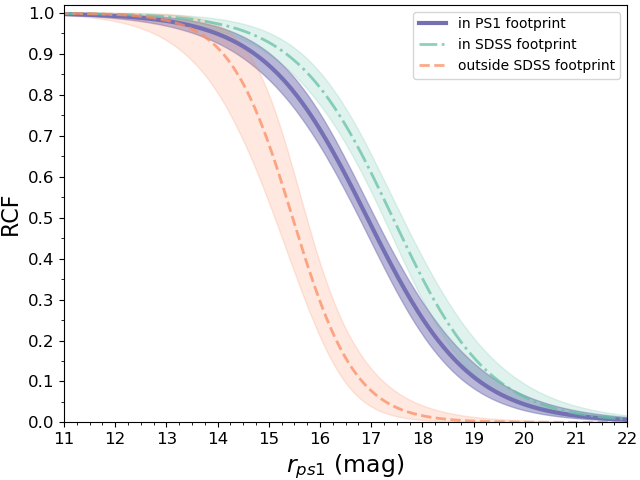

90, 50, 10% completeness = 14.73, 16.92, 19.12 mag, respectively


In [26]:
fig, ax = plt.subplots() 
ax.plot(ps1_grid[1:-1], p_ps150[1:-1], 
        lw=3,
        label='in PS1 footprint', color='#7570b3')
ax.fill_between(ps1_grid, p_ps15, p_ps195, 
                alpha=0.5, color='#7570b3')
ax.plot(ps1_grid[1:-1], p_ps1_sdss50[1:-1], 
        '-.', alpha=0.75, lw=2, 
        label='in SDSS footprint', color='#66c2a5')
ax.fill_between(ps1_grid, p_ps1_sdss5, p_ps1_sdss95, 
                alpha=0.2, color='#66c2a5')
ax.plot(ps1_grid[1:-1], p_no_sdss50[1:-1], 
        '--', alpha=0.75, lw=2, 
        label='outside SDSS footprint', color='#fc8d62')
ax.fill_between(ps1_grid, p_no_sdss5, p_no_sdss95, 
                alpha=0.2, color='#fc8d62')

ax.set_xlabel('$r_{ps1}$ (mag)', fontsize=17)
ax.set_ylabel('RCF', fontsize=16)
ax.tick_params(labelsize=12)
ax.set_xlim(11,22)
ax.set_ylim(0,1.02)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.legend(fancybox=True)

fig.subplots_adjust(left=0.1, right=0.98, top=0.99, bottom=0.12)
fig.savefig('RCF_r_band.pdf')


print('90, 50, 10% completeness = {:.2f}, {:.2f}, {:.2f} mag, respectively'.format(ps1_grid[np.argmin(np.abs(p_ps150-0.9))],
                                                                                   ps1_grid[np.argmin(np.abs(p_ps150-0.5))],
                                                                                   ps1_grid[np.argmin(np.abs(p_ps150-0.1))]))
